In [8]:
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plot

%matplotlib notebook

<IPython.core.display.Javascript object>


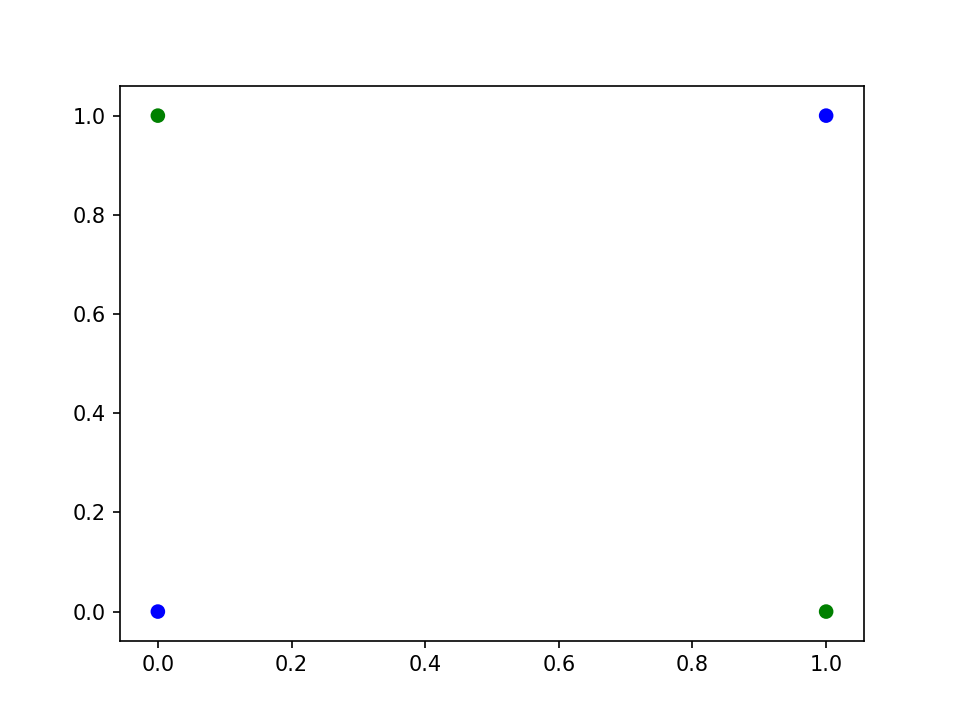

In [9]:
# illustration of xor problem
xor_inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [   (0.0,),     (1.0,),     (1.0,),     (0.0,)]
x = [0,0,1,1]
y = [0,1,0,1]
colors = ['b','g','g','b']
plot.scatter(x,y, c = colors)

In [4]:
import nest
import numpy as np
import numpy.ma as ma

from lsm.nest import LSM
from lsm.utils import poisson_generator

# convention: all times in [ms], except stated otherwise


def generate_stimulus_xor(stim_times, gen_burst, n_inputs=2):
    inp_states = np.random.randint(2, size=(n_inputs, np.size(stim_times)))
    inp_spikes = []

    for times in ma.masked_values(inp_states, 0) * stim_times:
        # for each input (neuron): generate spikes according to state (=1) and stimulus time-grid
        spikes = np.concatenate([t + gen_burst() for t in times.compressed()])

        # round to simulation precision
        spikes *= 10
        spikes = spikes.round() + 1.0
        spikes = spikes / 10.0

        inp_spikes.append(spikes)

    # astype(int) could be omitted, because False/True has the same semantics
    targets = np.logical_xor(*inp_states).astype(int)

    return inp_spikes, targets


def inject_spikes(inp_spikes, neuron_targets):
    spike_generators = nest.Create("spike_generator", len(inp_spikes))

    for sg, sp in zip(spike_generators, inp_spikes):
        nest.SetStatus([sg], {'spike_times': sp})

    delay = dict(distribution='normal_clipped', mu=10., sigma=20., low=3., high=200.)
    C_inp = 100  # int(N_E / 20)  # number of outgoing input synapses per input neuron

    nest.Connect(spike_generators, neuron_targets,
                 {'rule': 'fixed_outdegree',
                  'outdegree': C_inp},
                 {'model': 'static_synapse',
                  'delay': delay,
                  'weight': {'distribution': 'uniform',
                             'low': 2.5 * 10 * 5.0,
                             'high': 7.5 * 10 * 5.0}
                  })


# nest.SetKernelStatus({'print_time': True, 'local_num_threads': 11})

In [10]:
sim_time = 200000

# stimulus
stim_interval = 300
stim_length = 50
stim_rate = 200  # [1/s]

readout_delay = 10

stim_times = np.arange(stim_interval, sim_time - stim_length - readout_delay, stim_interval)
readout_times = stim_times + stim_length + readout_delay

def gen_stimulus_pattern(): return poisson_generator(stim_rate, t_stop=stim_length)

inp_spikes, targets = generate_stimulus_xor(stim_times, gen_burst=gen_stimulus_pattern)

lsm = LSM(n_exc=1000, n_inh=250, n_rec=500)

inject_spikes(inp_spikes, lsm.inp_nodes)

In [ ]:
# SIMULATE
nest.Simulate(sim_time)

In [11]:


readout_times = readout_times[5:]
targets = targets[5:]

states = lsm.get_states(readout_times, tau=20)

# add constant component to states for bias (TODO why?)
states = np.hstack([states, np.ones((np.size(states, 0), 1))])

n_examples = np.size(targets, 0)
n_examples_train = int(n_examples * 0.8)

train_states, test_states = states[:n_examples_train, :], states[n_examples_train:, :]
train_targets, test_targets = targets[:n_examples_train], targets[n_examples_train:]

readout_weights = lsm.compute_readout_weights(train_states, train_targets, reg_fact=5.0)

In [13]:
targets.shape

(661,)

In [7]:
print(states.shape)
print(targets.shape)
print(test_states.shape)
print(test_targets.shape)
print(train_states.shape)
print(train_targets.shape)
132+524
# inp_spikes[].shape
inp_spikes[0].shape
targets.shape
readout_times.shape

# plot.eventplot(train_states[0],linelengths=0.1)     
# plot.show()

(661, 501)
(661,)
(133, 501)
(133,)
(528, 501)
(528,)


(661,)

In [13]:
def classify(prediction):
    return (prediction >= 0.5).astype(int)

train_prediction = lsm.compute_prediction(train_states, readout_weights)
train_results = classify(train_prediction)

test_prediction = lsm.compute_prediction(test_states, readout_weights)
test_results = classify(test_prediction)

print("simulation time: {}ms".format(sim_time))
print("number of stimuli: {}".format(len(stim_times)))
print("size of each state: {}".format(np.size(states, 1)))

print("---------------------------------------")

def eval_prediction(prediction, targets, label):
    n_fails = sum(abs(prediction - targets))
    n_total = len(targets)
    print("mismatched {} examples: {:d}/{:d} [{:.1f}%]".format(label, n_fails, n_total, n_fails / n_total * 100))

eval_prediction(train_results, train_targets, "training")
eval_prediction(test_results, test_targets, "test")

NameError: name 'c' is not defined

In [52]:
import nest.topology as topp

help(nest)

lsm.PlotLayer(l)
plt.show()

Help on package nest:

NAME
    nest - Initializer of PyNEST.

PACKAGE CONTENTS
    hl_api
    lib (package)
    ll_api
    pynestkernel
    raster_plot
    tests (package)
    topology (package)
    visualization
    voltage_trace

SUBMODULES
    kernel

FUNCTIONS
    test()
        Runs all PyNEST unit tests.

FILE
    /usr/local/Cellar/nest/HEAD-10e0863_1/lib/python3.7/site-packages/nest/__init__.py




AttributeError: 'LSM' object has no attribute 'PlotLayer'

In [64]:
import nest.topology as tp
import matplotlib.pyplot as plt

# create a layer
l = tp.CreateLayer({'rows'      : 11,
                    'columns'   : 11,
                    'extent'    : [11.0, 11.0],
                    'elements'  : 'iaf_psc_alpha'})

# plot layer with all its nodes
nest.PlotLayer(l)
plt.show()

AttributeError: module 'nest' has no attribute 'PlotLayer'

In [72]:
nest.topology.PlotLayer(lsm)

TypeError: object of type 'LSM' has no len()